# Import

In [1]:
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import pandas as pd
import html
import re
import logging
import os
import requests

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# Chroma
import chromadb 
from chromadb.utils import embedding_functions
from langchain.vectorstores import Chroma

# Sentence Transformers
from sentence_transformers import SentenceTransformer

C:\Users\Nathan\anaconda3\envs\Html_embeddings\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize logging
logging.basicConfig(level=logging.INFO)

# Set up 

In [3]:
# Configuration
config = {
    'site1': {
        'index_path': "http://192.168.48.22:8082/repository/qa/QMS.html",
        'documentation': 'QMS-documentation'
    },
}

In [4]:
def get_all_links(base_url):
    # Send a GET request to the base URL
    response = requests.get(base_url)
    response.raise_for_status()  # Raise an exception for HTTP errors

    # Parse the content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract all anchor tags
    anchors = soup.find_all('a', href=True)

    # Convert relative URLs and fragments to absolute URLs
    absolute_urls = [urljoin(base_url, a['href']) for a in anchors]

    return absolute_urls

In [5]:
site_url = config['site1']['index_path']
linked_urls = get_all_links(site_url)

In [6]:
# Print the results
for url in linked_urls:
    print(url)

http://192.168.48.22:8082/repository/qa/QMS.html
https://gitlab-toulouse.kratos.us/qms/kratos-qms
http://192.168.48.22:8082/repository/qa/QMS.pdf
http://192.168.48.22:8082/repository/qa/QMS.html#introduction
http://192.168.48.22:8082/repository/qa/QMS.html#quality-management-system
http://192.168.48.22:8082/repository/qa/QMS.html#reference-documents
http://192.168.48.22:8082/repository/qa/QMS.html#list-of-processes
http://192.168.48.22:8082/repository/qa/QMS.html#documents
http://192.168.48.22:8082/repository/qa/QMS.html#human-resources
http://192.168.48.22:8082/repository/qa/QMS.html#infrastructure
http://192.168.48.22:8082/repository/qa/QMS.html#operations
http://192.168.48.22:8082/repository/qa/QMS.html#proposals-and-contracts
http://192.168.48.22:8082/repository/qa/QMS.html#purchasing
http://192.168.48.22:8082/repository/qa/QMS.html#quality
http://192.168.48.22:8082/repository/qa/QMS.html#shipping-and-receiving
http://192.168.48.22:8082/repository/qa/QMS.html#support
http://192.168

In [7]:
links = linked_urls

# Lists to store categorized links
html_links = []
pdf_links = []
xlsx_links = []
xls_links = []
docx_links = []
doc_links = []
pptx_links = []
zip_links = []

# Categorize links
for link in links:
    if link.endswith('.html'):
        html_links.append(link)
    elif link.endswith('.pdf'):
        pdf_links.append(link)
    elif link.endswith('.xlsx'):
        xlsx_links.append(link)
    elif link.endswith('.xls'):
        xls_links.append(link)
    elif link.endswith('.docx'):
        docx_links.append(link)
    elif link.endswith('.doc'):
        doc_links.append(link)
    elif link.endswith('.pptx'):
        pptx_links.append(link)
    elif link.endswith('.zip'):
        zip_links.append(link)

In [8]:
print("HTML:")
for link in html_links:
    print(link)

HTML:
http://192.168.48.22:8082/repository/qa/QMS.html
http://192.168.48.22:8082/repository/qa/Quality_Manual.html
http://192.168.48.22:8082/repository/qa/Kratos_Organization_Note.html
http://192.168.48.22:8082/repository/qa/Kratos_Diagram.html
http://qms-toulouse.kratos.us/QMS.html
http://qms-toulouse.kratos.us/internal/internal-process.html
http://192.168.48.22:8082/repository/qa/Document_Management.html
http://192.168.48.22:8082/repository/qa/Document_Publication.html
http://192.168.48.22:8082/repository/qa/Human_Resources.html
http://192.168.48.22:8082/repository/qa/Account_Management.html
http://192.168.48.22:8082/repository/qa/Infrastructure.html
http://192.168.48.22:8082/repository/qa/Project_Folder_Organization.html
http://192.168.48.22:8082/repository/qa/Configuration_Management.html
http://192.168.48.22:8082/repository/qa/Work%20Instructions/WI_Project_Library.html
http://192.168.48.22:8082/repository/qa/Configuration_Management_for_Projects.html
http://192.168.48.22:8082/rep

In [9]:
len(html_links)

42

In [10]:
 len(pdf_links)

25

In [11]:
pdf_links

['http://192.168.48.22:8082/repository/qa/QMS.pdf',
 'http://192.168.48.22:8082/repository/qa/Reference%20Documents/AFNOR_Certificate.pdf',
 'http://192.168.48.22:8082/repository/qa/Reference%20Documents/ISO_9001_2015_Norme.pdf',
 'http://192.168.48.22:8082/repository/qa/Reference%20Documents/BS_EN_ISO_9001_2015.pdf',
 'http://192.168.48.22:8082/repository/qa/Reference%20Documents/Limit_of_Authority.pdf',
 'http://192.168.48.22:8082/repository/qa/Templates/General/Kratos%20Style%20Guide.pdf',
 'http://192.168.48.22:8082/repository/qa/Templates/Human%20Resources/N2F_Procedure.pdf',
 'http://192.168.48.22:8082/repository/qa/Templates/Human%20Resources/N2F_FAQ.pdf',
 'http://192.168.48.22:8082/repository/qa/Templates/Infrastructure/Note_d_information_vidéosurveillance.pdf',
 'http://192.168.48.22:8082/repository/qa/Templates/Infrastructure/Note_d_information_Accès_par_badge.pdf',
 'http://192.168.48.22:8082/repository/qa/Templates/Process/Process_Identification_Purchasing.pdf',
 'http://1

# Scrap content

In [12]:
def fetch_html_from_url(url):
    response = requests.get(url)
    response.encoding = 'utf-8'
    response.raise_for_status()
    return response.text

In [13]:
def get_path(html_content, h='h1'):
    html_content.split(f'</{h}>', 0)
    soup = BeautifulSoup(html_content.split(f'</{h}>')[0], 'html.parser')
    h_text = soup.find(f'{h}').text.replace("¶", "")
    return '/' + h_text

In [14]:
def scrape_content_from_page(html_content, source, file_path):
    h1_split = html_content.split('<h1')
    list_split = list()
    list_path = list()
    list_source = list()  # For storing the documentation source
    list_file_path = list()
    path = ''
 
    for i, h1 in enumerate(h1_split):
        if i > 0:
            h1 = '<h1' + h1
            result = path.split('/')[:1] 
            path = '/'.join(result)
            path += get_path(h1, h='h1')      
 
        h2_split = h1.split('<h2')
        for j, h2 in enumerate(h2_split):
            if j > 0:
                h2 = '<h2' + h2
                result = path.split('/')[:2] 
                path = '/'.join(result)
                path += get_path(h2, h='h2')
            h3_split = h2.split('<h3')
            for k, h3 in enumerate(h3_split):
                if k > 0:
                    h3 = '<h3' + h3
                    result = path.split('/')[:3] 
                    path = '/'.join(result)
                    path += get_path(h3, h='h3')
 
                h4_split = h3.split('<h4')
                for l, h4 in enumerate(h4_split):
                    if l > 0: 
                        h4 = '<h4' + h4
                        result = path.split('/')[:4] 
                        path = '/'.join(result)
                        path += get_path(h4, h='h4')    
 
                    h5_split = h4.split('<h5')
                    # Look for href in the html content to add it to the link
                    regex_pattern = r'<h[1-6](.*?)<\/h[1-6]>'
                    header = re.search(regex_pattern, h5_split[0])
                    if header:
                        regex_pattern = r'href="#([^"]*)"'
                        match_href = re.search(regex_pattern, header.group(1))
                        regex_pattern = r'id="([^"]*)"'
                        match_id = re.search(regex_pattern, header.group(1))
                        if match_href:
                            href = '#' + match_href.group(1)
                        elif match_id:
                            href = '#' + match_id.group(1)
                        else:
                            href = ''
                    else:
                        href = ''
                    # get the text from html content
                    soup = BeautifulSoup(h5_split[0].split('\n', 1)[1], "lxml")
                    h5_split = soup.get_text()
                    list_split.append(h5_split)
                    list_path.append(path)
                    list_source.append(source)  # Add the documentation source for each content
                    list_file_path.append(f'{file_path}{href}')
    df = pd.DataFrame()
    df['documentation'] = list_source  # Add the documentation source column
    df['path'] = list_path
    df['text'] = list_split
    df['file_path'] = list_file_path  # adding local path to the df for each row
    return df

In [15]:
def process_links(site_config):
    index_content = fetch_html_from_url(site_config['index_path'])
    soup = BeautifulSoup(index_content, 'html.parser')
    links = [a['href'] for a in soup.find_all('a', href=True) if a['href'].endswith('.html')]
    
    logging.info(f"Found {len(links)} links to process for {site_config['documentation']}.")
    
    data_frames = []
    for link in links:
        full_url = site_config['base_url'] + link  # Construct the full URL
        try:
            page_content = fetch_html_from_url(full_url)
            df_temp = scrape_content_from_page(page_content, site_config['documentation'], full_url)
            
            # Check if df_temp is not empty or None
            if df_temp is not None and not df_temp.empty:
                data_frames.append(df_temp)
            else:
                logging.warning(f"Empty dataframe returned from {full_url}.")
            
        except Exception as e:
            logging.error(f"Error processing {full_url}: {e}")
    
    logging.info(f"Processed {len(data_frames)} dataframes for {site_config['documentation']}.")
    return data_frames


In [16]:
def process_links_from_list(links, documentation_label):
    logging.info(f"Found {len(links)} links to process for {documentation_label}.")
    
    data_frames = []
    for link in links:
        try:
            page_content = fetch_html_from_url(link)
            df_temp = scrape_content_from_page(page_content, documentation_label, link)
            
            # Check if df_temp is not empty or None
            if df_temp is not None and not df_temp.empty:
                data_frames.append(df_temp)
            else:
                logging.warning(f"Empty dataframe returned from {link}.")
            
        except Exception as e:
            logging.error(f"Error processing {link}: {e}")
    
    logging.info(f"Processed {len(data_frames)} dataframes for {documentation_label}.")
    return data_frames

# Scrape the Content and Store in a DataFrame:

In [17]:
logging.basicConfig(level=logging.INFO)

In [18]:
# Process the links and extract content
data_frames = process_links_from_list(html_links, "Quality Manual")

INFO:root:Found 42 links to process for Quality Manual.
ERROR:root:Error processing http://qms-toulouse.kratos.us/QMS.html: HTTPConnectionPool(host='qms-toulouse.kratos.us', port=80): Max retries exceeded with url: /QMS.html (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001C78E30CE90>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
ERROR:root:Error processing http://qms-toulouse.kratos.us/internal/internal-process.html: HTTPConnectionPool(host='qms-toulouse.kratos.us', port=80): Max retries exceeded with url: /internal/internal-process.html (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001C78E30C910>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
ERROR:root:Error processing http://192.168.48.22:8082/repository/qa/Work%20Instructions/WI_Project_Library.html: 404 Client Error: Work Instructions/WI_Project_Library.html for url: http://192.168.48.22:8082/repository/q

In [19]:
# Combine the list of DataFrames into a single DataFrame
df = pd.concat(data_frames, ignore_index=True)

# Turn to DF

In [20]:
df

,documentation,path,text,file_path
0,Quality Manual,,\n\n\n\n\nQuality Management System\n\n\n\n\n\n\n,http://192.168.48.22:8082/repository/qa/QMS.html
1,Quality Manual,/Quality Management System,\n,http://192.168.48.22:8082/repository/qa/QMS.html
2,Quality Manual,/Quality Management System/\nTable of Contents\n,Table of Contents\n\n\nIntroduction\nQuality M...,http://192.168.48.22:8082/repository/qa/QMS.html
3,Quality Manual,/1 Introduction,"Welcome to Kratos QMS\nQuality Policy\n""Our go...",http://192.168.48.22:8082/repository/qa/QMS.ht...
4,Quality Manual,/2 Quality Management System,\nKratos Communications SAS Quality Manual\nKr...,http://192.168.48.22:8082/repository/qa/QMS.ht...
...,...,...,...,...
710,Quality Manual,/4 Records,\n\n\nName\nLocation\nResponsability\nMinimum ...,http://192.168.48.22:8082/repository/qa/Facili...
711,Quality Manual,,\n\n\n\n\nTemplate Version\n\n\n\n\n\n\n,http://192.168.48.22:8082/repository/qa/templa...
712,Quality Manual,/Template Version,\n,http://192.168.48.22:8082/repository/qa/templa...
713,Quality Manual,/Template Version/\nTable of Contents\n,Table of Contents\n\n\nTemplate Version\n\n,http://192.168.48.22:8082/repository/qa/templa...


In [21]:
df.iloc[0,2]

'\n\n\n\n\nQuality Management System\n\n\n\n\n\n\n'

In [22]:
df.iloc[89,2]

'Kratos management formally reviews the suitability, adequacy, and effectiveness of the QMS, and discusses opportunities for improvement. Management Review meetings are scheduled and conducted yearly.\nThe management review will be holding once a year, after the completion of the fiscal year.\nAn annual quality management audit plan is prepared by the Quality Manager and approved by the President of Kratos.\n'

In [23]:
df.iloc[336,2]

'\n\nShould you use ChatGPT or similar Assistant ?\n\nYES !!! At least try - These are awesome tools !\nBUT YOU ARE RESPONSIBLE :\n\nNEVER publish confidential or company proprietary information (Same as for any online platform): discussions with the assistant are not our property\nNEVER blindly take an answer as THE right one\n\nErrors are common and difficult to spot in answers – check the validity\nGenerated code snippets may be someone else’s IP – don’t reuse blindly\n\n\n\n\n\n'

# Clean data

In [24]:
def clean_text(text):
    # Whitespace normalization
    text = ' '.join(text.split())
    
    # Handling newline characters to create a visual separation
    text = text.replace('\n', ' ')

    # Handle LaTeX math expressions: This step can be enhanced further based on specific needs
    # The idea here is to isolate math expressions so that they don't get affected by other cleaning operations
    math_expressions = re.findall(r'\\\(.*?\\\)', text)
    for math_expr in math_expressions:
        placeholder = math_expr.replace(' ', '_')
        text = text.replace(math_expr, placeholder)

    # Removing unwanted characters like ¶
    text = text.replace('¶', '')

    # Punctuation spacing: Ensure spaces before and after punctuation
    text = re.sub(r'(?<=[\w])([.,;:!?\(\)\[\]])', r' \1', text)
    text = re.sub(r'([.,;:!?\(\)\[\]])(?=[\w])', r'\1 ', text)

    # Replace back the LaTeX math expressions
    for math_expr in math_expressions:
        placeholder = math_expr.replace(' ', '_')
        text = text.replace(placeholder, math_expr)

    
    return text

In [25]:
# Apply this function to the entire 'content' column
df['text'] = df['text'].apply(clean_text)

In [26]:
df['text'].iloc[0]

'Quality Management System'

In [27]:
df['text'].iloc[89]

'Kratos management formally reviews the suitability , adequacy , and effectiveness of the QMS , and discusses opportunities for improvement . Management Review meetings are scheduled and conducted yearly . The management review will be holding once a year , after the completion of the fiscal year . An annual quality management audit plan is prepared by the Quality Manager and approved by the President of Kratos .'

In [28]:
df['text'].iloc[336]

'Should you use ChatGPT or similar Assistant ? YES !!! At least try - These are awesome tools ! BUT YOU ARE RESPONSIBLE : NEVER publish confidential or company proprietary information ( Same as for any online platform ): discussions with the assistant are not our property NEVER blindly take an answer as THE right one Errors are common and difficult to spot in answers – check the validity Generated code snippets may be someone else’s IP – don’t reuse blindly'

In [29]:
df['text'].iloc[400]

'Docker : GLOBAL : ( HTTP ) 192 . 168 . 48 . 22 : 8084 ( custom images + all proxies below in that order ) Custom : ( HTTP ) 192 . 168 . 48 . 22 : 8083 ( hosted custom images only ) We usually use it in CI/CD variables in GitLab ( we may not use this nexus instance forever ; IP address will change one day ).'

# Format size for emebddings

In [30]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

In [31]:
df.iloc[336]

documentation                                       Quality Manual
path             /5 Chapter 1 – The basics/5.8 Development envi...
text             Should you use ChatGPT or similar Assistant ? ...
file_path        http://192.168.48.22:8082/repository/qa/Softwa...
word_count                                                      81
Name: 336, dtype: object

C:\Users\Nathan\anaconda3\envs\Html_embeddings\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Nathan\anaconda3\envs\Html_embeddings\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


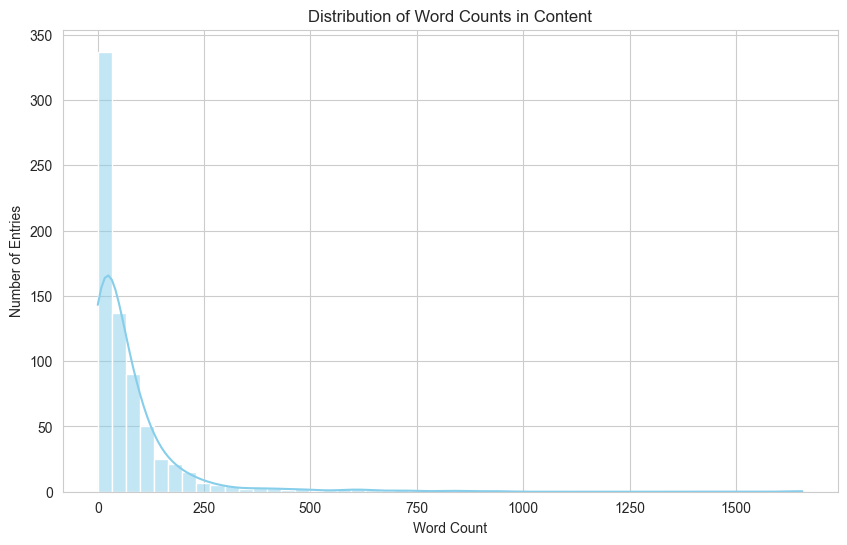

In [32]:
# Set Seaborn style
sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Word Counts in Content')
plt.xlabel('Word Count')
plt.ylabel('Number of Entries')
plt.show()

C:\Users\Nathan\anaconda3\envs\Html_embeddings\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Nathan\anaconda3\envs\Html_embeddings\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


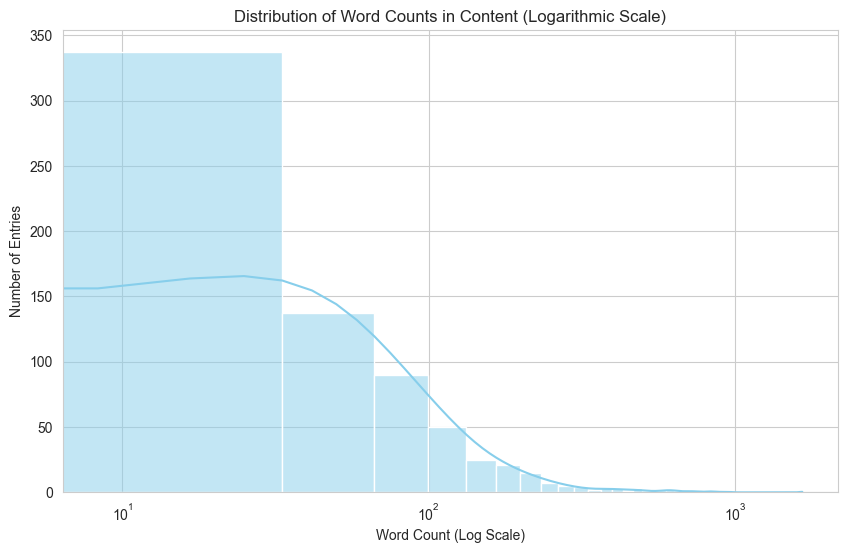

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True, color='skyblue')
plt.xscale('log')
plt.title('Distribution of Word Counts in Content (Logarithmic Scale)')
plt.xlabel('Word Count (Log Scale)')
plt.ylabel('Number of Entries')
plt.show()

# Data exploration

In [34]:
df

,documentation,path,text,file_path,word_count
0,Quality Manual,,Quality Management System,http://192.168.48.22:8082/repository/qa/QMS.html,3
1,Quality Manual,/Quality Management System,,http://192.168.48.22:8082/repository/qa/QMS.html,0
2,Quality Manual,/Quality Management System/\nTable of Contents\n,Table of Contents Introduction Quality Managem...,http://192.168.48.22:8082/repository/qa/QMS.html,40
3,Quality Manual,/1 Introduction,"Welcome to Kratos QMS Quality Policy ""Our goal...",http://192.168.48.22:8082/repository/qa/QMS.ht...,62
4,Quality Manual,/2 Quality Management System,Kratos Communications SAS Quality Manual Krato...,http://192.168.48.22:8082/repository/qa/QMS.ht...,33
...,...,...,...,...,...
710,Quality Manual,/4 Records,Name Location Responsability Minimum Backup Fr...,http://192.168.48.22:8082/repository/qa/Facili...,61
711,Quality Manual,,Template Version,http://192.168.48.22:8082/repository/qa/templa...,2
712,Quality Manual,/Template Version,,http://192.168.48.22:8082/repository/qa/templa...,0
713,Quality Manual,/Template Version/\nTable of Contents\n,Table of Contents Template Version,http://192.168.48.22:8082/repository/qa/templa...,5


## Remove empty 

In [35]:
# Check for NaN or empty values in 'path' column
empty_path = df[df['path'].isna() | (df['path'].str.strip() == '')]

In [36]:
len(empty_path)

38

In [37]:
empty_path

,documentation,path,text,file_path,word_count
0,Quality Manual,,Quality Management System,http://192.168.48.22:8082/repository/qa/QMS.html,3
20,Quality Manual,,Quality Manual,http://192.168.48.22:8082/repository/qa/Qualit...,2
96,Quality Manual,,Kratos Communications SAS Organization note,http://192.168.48.22:8082/repository/qa/Kratos...,5
132,Quality Manual,,Kratos Diagram,http://192.168.48.22:8082/repository/qa/Kratos...,2
138,Quality Manual,,Document Management Process,http://192.168.48.22:8082/repository/qa/Docume...,3
157,Quality Manual,,Document Publication,http://192.168.48.22:8082/repository/qa/Docume...,2
165,Quality Manual,,Human Resources,http://192.168.48.22:8082/repository/qa/Human_...,2
171,Quality Manual,,Account Management,http://192.168.48.22:8082/repository/qa/Accoun...,2
184,Quality Manual,,Infrastructure,http://192.168.48.22:8082/repository/qa/Infras...,1
211,Quality Manual,,Project Folder Organization,http://192.168.48.22:8082/repository/qa/Projec...,3


In [38]:
# Check for NaN or empty values in 'text' column
empty_text = df[df['text'].isna() | (df['text'].str.strip() == '')]
len(empty_text)

120

In [39]:
empty_text

,documentation,path,text,file_path,word_count
1,Quality Manual,/Quality Management System,,http://192.168.48.22:8082/repository/qa/QMS.html,0
6,Quality Manual,/4 List of Processes,,http://192.168.48.22:8082/repository/qa/QMS.ht...,0
21,Quality Manual,/Quality Manual,,http://192.168.48.22:8082/repository/qa/Qualit...,0
35,Quality Manual,/5 Leadership,,http://192.168.48.22:8082/repository/qa/Qualit...,0
36,Quality Manual,/5 Leadership/5.1 Leadership and Commitment,,http://192.168.48.22:8082/repository/qa/Qualit...,0
...,...,...,...,...,...
691,Quality Manual,/Facility Access Control Policy,,http://192.168.48.22:8082/repository/qa/Facili...,0
694,Quality Manual,/2 Process,,http://192.168.48.22:8082/repository/qa/Facili...,0
695,Quality Manual,/2 Process/2.1 People Identification,,http://192.168.48.22:8082/repository/qa/Facili...,0
708,Quality Manual,/3 Emergency cases,,http://192.168.48.22:8082/repository/qa/Facili...,0


In [40]:
# Drop the rows with NaN or empty values from the main DataFrame
df = df.drop(empty_path.index)
df = df.drop(empty_text.index)
# Reset the index after dropping rows, if desired
df = df.reset_index(drop=True)

In [41]:
df

,documentation,path,text,file_path,word_count
0,Quality Manual,/Quality Management System/\nTable of Contents\n,Table of Contents Introduction Quality Managem...,http://192.168.48.22:8082/repository/qa/QMS.html,40
1,Quality Manual,/1 Introduction,"Welcome to Kratos QMS Quality Policy ""Our goal...",http://192.168.48.22:8082/repository/qa/QMS.ht...,62
2,Quality Manual,/2 Quality Management System,Kratos Communications SAS Quality Manual Krato...,http://192.168.48.22:8082/repository/qa/QMS.ht...,33
3,Quality Manual,/3 Reference Documents,ISO 9001 - Systèmes de management de la qualit...,http://192.168.48.22:8082/repository/qa/QMS.ht...,23
4,Quality Manual,/4 List of Processes/4.1 Documents,Process Template Document Management Product-P...,http://192.168.48.22:8082/repository/qa/QMS.ht...,26
...,...,...,...,...,...
552,Quality Manual,"/2 Process/2.4 Restricted rooms, first floor/2...",The FSO organizes an annual review of the acce...,http://192.168.48.22:8082/repository/qa/Facili...,56
553,Quality Manual,/3 Emergency cases/3.1 General emergency,"In case of emergencies , in particular emergen...",http://192.168.48.22:8082/repository/qa/Facili...,112
554,Quality Manual,/4 Records,Name Location Responsability Minimum Backup Fr...,http://192.168.48.22:8082/repository/qa/Facili...,61
555,Quality Manual,/Template Version/\nTable of Contents\n,Table of Contents Template Version,http://192.168.48.22:8082/repository/qa/templa...,5


In [42]:
df.iloc[3,3]

'http://192.168.48.22:8082/repository/qa/QMS.html#reference-documents'

## Remove Table of content

In [43]:
# Filter rows where 'path' contains 'Table of Contents'
df = df[~df['path'].str.contains('Table of Contents', na=False, case=False)]
df = df.reset_index(drop=True)
len(df)

519

In [44]:
df

,documentation,path,text,file_path,word_count
0,Quality Manual,/1 Introduction,"Welcome to Kratos QMS Quality Policy ""Our goal...",http://192.168.48.22:8082/repository/qa/QMS.ht...,62
1,Quality Manual,/2 Quality Management System,Kratos Communications SAS Quality Manual Krato...,http://192.168.48.22:8082/repository/qa/QMS.ht...,33
2,Quality Manual,/3 Reference Documents,ISO 9001 - Systèmes de management de la qualit...,http://192.168.48.22:8082/repository/qa/QMS.ht...,23
3,Quality Manual,/4 List of Processes/4.1 Documents,Process Template Document Management Product-P...,http://192.168.48.22:8082/repository/qa/QMS.ht...,26
4,Quality Manual,/4 List of Processes/4.2 Human Resources,Process Template Work Instructions Human Resou...,http://192.168.48.22:8082/repository/qa/QMS.ht...,37
...,...,...,...,...,...
514,Quality Manual,"/2 Process/2.4 Restricted rooms, first floor",Access to certain rooms is limited by a code l...,http://192.168.48.22:8082/repository/qa/Facili...,85
515,Quality Manual,"/2 Process/2.4 Restricted rooms, first floor/2...",The FSO organizes an annual review of the acce...,http://192.168.48.22:8082/repository/qa/Facili...,56
516,Quality Manual,/3 Emergency cases/3.1 General emergency,"In case of emergencies , in particular emergen...",http://192.168.48.22:8082/repository/qa/Facili...,112
517,Quality Manual,/4 Records,Name Location Responsability Minimum Backup Fr...,http://192.168.48.22:8082/repository/qa/Facili...,61


In [45]:
df[df['path'].str.contains('Table of Contents', na=False, case=False)]

,documentation,path,text,file_path,word_count


## Remove duplicates

In [46]:
duplicates_specific = df[df.duplicated(subset=['text'])]
len(duplicates_specific)

5

In [47]:
duplicates_specific

,documentation,path,text,file_path,word_count
140,Quality Manual,/2 Applicable and Reference Documents/2.1 Appl...,None,http://192.168.48.22:8082/repository/qa/Infras...,1
253,Quality Manual,/6 Chapter 2 – The details/6.2 How we use Git,center,http://192.168.48.22:8082/repository/qa/Softwa...,1
266,Quality Manual,/6 Chapter 2 – The details/6.4 Design standard...,center,http://192.168.48.22:8082/repository/qa/Softwa...,1
425,Quality Manual,/1 Introduction,This procedure describes the action to carry o...,http://192.168.48.22:8082/repository/qa/Purcha...,12
478,Quality Manual,/2 Roles/2.2 Shipping Manager,The SM supports the project manager in all mat...,http://192.168.48.22:8082/repository/qa/Handli...,26


In [48]:
print(df[df['text'] == "None"])

      documentation                                               path  text  \
132  Quality Manual  /2 Applicable and Reference Documents/2.1 Appl...  None   
140  Quality Manual  /2 Applicable and Reference Documents/2.1 Appl...  None   

                                             file_path  word_count  
132  http://192.168.48.22:8082/repository/qa/Accoun...           1  
140  http://192.168.48.22:8082/repository/qa/Infras...           1  


In [49]:
df = df.drop(duplicates_specific.index)
df = df.reset_index(drop=True)

In [50]:
df

,documentation,path,text,file_path,word_count
0,Quality Manual,/1 Introduction,"Welcome to Kratos QMS Quality Policy ""Our goal...",http://192.168.48.22:8082/repository/qa/QMS.ht...,62
1,Quality Manual,/2 Quality Management System,Kratos Communications SAS Quality Manual Krato...,http://192.168.48.22:8082/repository/qa/QMS.ht...,33
2,Quality Manual,/3 Reference Documents,ISO 9001 - Systèmes de management de la qualit...,http://192.168.48.22:8082/repository/qa/QMS.ht...,23
3,Quality Manual,/4 List of Processes/4.1 Documents,Process Template Document Management Product-P...,http://192.168.48.22:8082/repository/qa/QMS.ht...,26
4,Quality Manual,/4 List of Processes/4.2 Human Resources,Process Template Work Instructions Human Resou...,http://192.168.48.22:8082/repository/qa/QMS.ht...,37
...,...,...,...,...,...
509,Quality Manual,"/2 Process/2.4 Restricted rooms, first floor",Access to certain rooms is limited by a code l...,http://192.168.48.22:8082/repository/qa/Facili...,85
510,Quality Manual,"/2 Process/2.4 Restricted rooms, first floor/2...",The FSO organizes an annual review of the acce...,http://192.168.48.22:8082/repository/qa/Facili...,56
511,Quality Manual,/3 Emergency cases/3.1 General emergency,"In case of emergencies , in particular emergen...",http://192.168.48.22:8082/repository/qa/Facili...,112
512,Quality Manual,/4 Records,Name Location Responsability Minimum Backup Fr...,http://192.168.48.22:8082/repository/qa/Facili...,61


## Remove short sentences

In [51]:
threshold = 20
smol = df[df['text'].str.split().str.len() < threshold]
smol = smol.sort_values(by='word_count')

In [52]:
smol

,documentation,path,text,file_path,word_count
132,Quality Manual,/2 Applicable and Reference Documents/2.1 Appl...,None,http://192.168.48.22:8082/repository/qa/Accoun...,1
235,Quality Manual,/5 Chapter 1 – The basics/5.3 Software develop...,center,http://192.168.48.22:8082/repository/qa/Softwa...,1
387,Quality Manual,/5 Process Activities Details,Purchasing Process,http://192.168.48.22:8082/repository/qa/Purcha...,2
413,Quality Manual,/2 Applicable and Reference Documents/2.2 Refe...,Purchasing Procedure,http://192.168.48.22:8082/repository/qa/Vendor...,2
466,Quality Manual,/3 Receiving Process,Receiving Process,http://192.168.48.22:8082/repository/qa/Receiv...,2
...,...,...,...,...,...
138,Quality Manual,/1 Introduction/1.1 Identification,The process Identification is under Process_Id...,http://192.168.48.22:8082/repository/qa/Infras...,18
168,Quality Manual,/2 Project Folder Organization/2.3 Project Man...,This folder contains a copy of all invoices se...,http://192.168.48.22:8082/repository/qa/Projec...,18
499,Quality Manual,/2 Process/2.1 People Identification/2.1.1 Cat...,KComms SAS employees : Persons who have an emp...,http://192.168.48.22:8082/repository/qa/Facili...,19
229,Quality Manual,/2 Software Developers’ Guide/2.2 The usual co...,Code quality helps to : Keep low costs of chan...,http://192.168.48.22:8082/repository/qa/Softwa...,19


In [53]:
for index, row in smol.iterrows():
    print(f"Word Count: {row['word_count']}\nSentence: {row['text']}\n{'-'*50}")


Word Count: 1
Sentence: None
--------------------------------------------------
Word Count: 1
Sentence: center
--------------------------------------------------
Word Count: 2
Sentence: Purchasing Process
--------------------------------------------------
Word Count: 2
Sentence: Purchasing Procedure
--------------------------------------------------
Word Count: 2
Sentence: Receiving Process
--------------------------------------------------
Word Count: 3
Sentence: Quality Process scope
--------------------------------------------------
Word Count: 4
Sentence: Purchase Order Reception Form
--------------------------------------------------
Word Count: 4
Sentence: center w : 500px
--------------------------------------------------
Word Count: 4
Sentence: The Kratos global organization
--------------------------------------------------
Word Count: 4
Sentence: https ://owasp . org/www-project-top-ten/
--------------------------------------------------
Word Count: 6
Sentence: THe Process id

In [54]:
df = df.drop(smol.index)
df = df.reset_index(drop=True)

In [55]:
df

,documentation,path,text,file_path,word_count
0,Quality Manual,/1 Introduction,"Welcome to Kratos QMS Quality Policy ""Our goal...",http://192.168.48.22:8082/repository/qa/QMS.ht...,62
1,Quality Manual,/2 Quality Management System,Kratos Communications SAS Quality Manual Krato...,http://192.168.48.22:8082/repository/qa/QMS.ht...,33
2,Quality Manual,/3 Reference Documents,ISO 9001 - Systèmes de management de la qualit...,http://192.168.48.22:8082/repository/qa/QMS.ht...,23
3,Quality Manual,/4 List of Processes/4.1 Documents,Process Template Document Management Product-P...,http://192.168.48.22:8082/repository/qa/QMS.ht...,26
4,Quality Manual,/4 List of Processes/4.2 Human Resources,Process Template Work Instructions Human Resou...,http://192.168.48.22:8082/repository/qa/QMS.ht...,37
...,...,...,...,...,...
434,Quality Manual,"/2 Process/2.4 Restricted rooms, first floor",Access to certain rooms is limited by a code l...,http://192.168.48.22:8082/repository/qa/Facili...,85
435,Quality Manual,"/2 Process/2.4 Restricted rooms, first floor/2...",The FSO organizes an annual review of the acce...,http://192.168.48.22:8082/repository/qa/Facili...,56
436,Quality Manual,/3 Emergency cases/3.1 General emergency,"In case of emergencies , in particular emergen...",http://192.168.48.22:8082/repository/qa/Facili...,112
437,Quality Manual,/4 Records,Name Location Responsability Minimum Backup Fr...,http://192.168.48.22:8082/repository/qa/Facili...,61


# Final preview

In [56]:
has_nan_or_none = df['path'].isnull().any()
print(f"Has NaN or None values in 'path': {has_nan_or_none}")
count_nan_or_none = df['path'].isnull().sum()
print(f"Number of NaN or None values in 'path': {count_nan_or_none}")


Has NaN or None values in 'path': False
Number of NaN or None values in 'path': 0


In [57]:
has_empty_string = (df['path'] == "").any()
print(f"Has empty strings in 'path': {has_empty_string}")
count_empty_string = (df['path'] == "").sum()
print(f"Number of empty strings in 'path': {count_empty_string}")


Has empty strings in 'path': False
Number of empty strings in 'path': 0


# Exploration 

In [ ]:
fr = final_df[final_df['path'] == '/2 Example of email to be sent to the subcontracting company']

In [ ]:
fr.iloc[0,2]

In [ ]:
# Original string with encoding issues
original_str = 'Bonjour , Dans le cadre de notre bon de commande KC-XXXXX-PO-YYYY_ZZ , nous avons besoin quâ\x80\x99un dÃ©placement soit effectuÃ© du XX/XX/XXXX au YY/YY/YYYY en ( pays ). Veuillez trouver en piÃ¨ce jointe la demande de dÃ©placement contenant les dÃ©tails nÃ©cessaires . Pouvez-vous confirmer la bonne rÃ©ception de cette demande dans les 3 jours ouvrÃ©s ? Cordialement Last modification of the file the 2023-09-01 11 : 58 : 15 +0200 with version 7e97094382d4cae646d5c9560a6c582f064a493b Generated with global version de4d97563dd503add2b3c6a21a782e005e97b3ca on 2023-10-02 12 : 50 : 21 +0000'

# Step 1: Convert the wrongly encoded text into "bytes" assuming it was incorrectly decoded using 'latin1'
bytes_str = original_str.encode('latin1')

# Step 2: Decode the bytes back into a string using 'utf-8'
correctly_decoded_str = bytes_str.decode('utf-8')

# Print or use the correctly decoded string
print(correctly_decoded_str)


In [ ]:
def correct_encoding(text):
    try:
        return text.encode('latin1').decode('utf-8')
    except AttributeError:  # handles cases where the text is not a string (e.g., NaN)
        return text
    except UnicodeDecodeError:  # handles cases where decoding fails
        return text  # or any other action you see fit

In [ ]:
# Apply the correction to the 'text' column
df['text'] = df['text'].apply(correct_encoding)

In [ ]:
df

In [58]:
final_df = df

# Change Path 

In [59]:
df.iloc[3,3]

'http://192.168.48.22:8082/repository/qa/QMS.html#documents'

In [60]:
final_df = df

In [61]:
def modify_path(row):
    # Extract the last part of the file_path (after the last '/')
    file_name = row['file_path'].split('/')[-1]
    
    # Remove the extension (.html) to get only the name
    name_without_extension = file_name.split('.')[0]
    
    # Add the extracted name to the beginning of the 'path' with '/'
    new_path = '/' + name_without_extension + row['path']
    
    # Modify the 'path' in the row
    row['path'] = new_path
    
    return row

In [62]:
test_df = final_df.apply(modify_path, axis=1)

In [63]:
test_df.iloc[1]

documentation                                       Quality Manual
path                              /QMS/2 Quality Management System
text             Kratos Communications SAS Quality Manual Krato...
file_path        http://192.168.48.22:8082/repository/qa/QMS.ht...
word_count                                                      33
Name: 1, dtype: object

In [64]:
test_df.iloc[1,3]

'http://192.168.48.22:8082/repository/qa/QMS.html#quality-management-system'

In [65]:
final_df = test_df

In [66]:
final_df

,documentation,path,text,file_path,word_count
0,Quality Manual,/QMS/1 Introduction,"Welcome to Kratos QMS Quality Policy ""Our goal...",http://192.168.48.22:8082/repository/qa/QMS.ht...,62
1,Quality Manual,/QMS/2 Quality Management System,Kratos Communications SAS Quality Manual Krato...,http://192.168.48.22:8082/repository/qa/QMS.ht...,33
2,Quality Manual,/QMS/3 Reference Documents,ISO 9001 - Systèmes de management de la qualit...,http://192.168.48.22:8082/repository/qa/QMS.ht...,23
3,Quality Manual,/QMS/4 List of Processes/4.1 Documents,Process Template Document Management Product-P...,http://192.168.48.22:8082/repository/qa/QMS.ht...,26
4,Quality Manual,/QMS/4 List of Processes/4.2 Human Resources,Process Template Work Instructions Human Resou...,http://192.168.48.22:8082/repository/qa/QMS.ht...,37
...,...,...,...,...,...
434,Quality Manual,/Facility_Access_Control_Policy/2 Process/2.4 ...,Access to certain rooms is limited by a code l...,http://192.168.48.22:8082/repository/qa/Facili...,85
435,Quality Manual,/Facility_Access_Control_Policy/2 Process/2.4 ...,The FSO organizes an annual review of the acce...,http://192.168.48.22:8082/repository/qa/Facili...,56
436,Quality Manual,/Facility_Access_Control_Policy/3 Emergency ca...,"In case of emergencies , in particular emergen...",http://192.168.48.22:8082/repository/qa/Facili...,112
437,Quality Manual,/Facility_Access_Control_Policy/4 Records,Name Location Responsability Minimum Backup Fr...,http://192.168.48.22:8082/repository/qa/Facili...,61


# Store in Chroma

In [67]:
chroma_client = client = chromadb.PersistentClient(path='C:/Users/Nathan/Kratos_data-Science/Chroma/v8')

INFO:chromadb.telemetry.posthog:Anonymized telemetry enabled. See https://docs.trychroma.com/telemetry for more information.


In [68]:
model = SentenceTransformer('all-MiniLM-L6-v2',  device='cuda')

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


In [69]:
chroma_client.list_collections()

[Collection(name=Skyminer), Collection(name=QMS-T), Collection(name=EPOCH-T)]

In [70]:
chroma_client.delete_collection(name="QMS-D")

ValueError: Collection QMS-D does not exist.

In [ ]:
# Initialize Chroma
vectorstore = chroma_client.get_or_create_collection(name="QMS-D")

In [ ]:
# Lists to store the extracted information from documents
documents_list = []
embeddings_list = []
metadatas_list = []
ids_list = []

# Assuming 'content' in your dataframe is what you consider as the document/page_content
for _, row in final_df.iterrows():
    embedding = model.encode(row['text'])
    
    # Constructing metadata
    metadata = {
        "source": f"{row['path']}",
        "documentation": row['documentation'],
        "file_path": row['file_path'],
        "word_count": row['word_count']
    }

    documents_list.append(row['text'])
    embeddings_list.append(embedding.tolist())
    metadatas_list.append(metadata)

# Generating IDs for the documents
ids_list = ["v" + str(i + 1) for i in range(len(documents_list))]

# Add the embedded documents to the collection in Chroma
vectorstore.add(
    documents=documents_list,
    embeddings=embeddings_list,
    metadatas=metadatas_list,
    ids=ids_list
)


In [ ]:
vectorstore

In [ ]:
print("There are", vectorstore.count(), "in the collection")

# Store in Chroma with cosin 

In [71]:
chroma_client = client = chromadb.PersistentClient(path='C:/Users/Nathan/Kratos_data-Science/Chroma/v8')
model = SentenceTransformer('all-MiniLM-L6-v2',  device='cuda')

INFO:chromadb.telemetry.posthog:Anonymized telemetry enabled. See https://docs.trychroma.com/telemetry for more information.
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


In [72]:
chroma_client.list_collections()

[Collection(name=Skyminer), Collection(name=QMS-T), Collection(name=EPOCH-T)]

In [73]:
# Initialize Chroma
vectorstore = chroma_client.get_or_create_collection(name="QMS-D",  metadata={"hnsw:space": "cosine"})

In [74]:
# Lists to store the extracted information from documents
documents_list = []
embeddings_list = []
metadatas_list = []
ids_list = []

# Assuming 'content' in your dataframe is what you consider as the document/page_content
for _, row in final_df.iterrows():
    embedding = model.encode(row['text'])
    
    # Constructing metadata
    metadata = {
        "source": f"{row['path']}",
        "documentation": row['documentation'],
        "file_path": row['file_path'],
        "word_count": row['word_count']
    }

    documents_list.append(row['text'])
    embeddings_list.append(embedding.tolist())
    metadatas_list.append(metadata)

# Generating IDs for the documents
ids_list = ["v" + str(i + 1) for i in range(len(documents_list))]

# Add the embedded documents to the collection in Chroma
vectorstore.add(
    documents=documents_list,
    embeddings=embeddings_list,
    metadatas=metadatas_list,
    ids=ids_list
)

Batches: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]


Batches: 100%|██████████| 1/1 [00:00<00:00, 166.64it/s]


Batches: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]


Batches: 100%|██████████| 1/1 [00:00<00:00, 111.10it/s]


In [ ]:
import torch
torch.cuda.is_available()